In [1]:
# notes:

# inventory, item stock, prediction for inventory
# f.e. next month how we will sell from each item

# top most selling products
# top most high selling products


# no missing records in the time-series model
# consecutive days - datetimeformat
# date column as index!!
# Multi-series forecasting, arima

# model prophet- from meta -> i can specify country

# Importing libraries and cleaned dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error

from functions import prophet_model

#import holidays 

Importing plotly failed. Interactive plots will not work.


In [3]:
# Disabling a specific type of warning from Jupyter, that I know if mistaken for something else
pd.options.mode.chained_assignment = None 

**Original Dataset**:

Chen,Daqing. (2015). Online Retail. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/352/online+retail

In [4]:
# Importing two datasets, to be able to compare performance
# one cleaned dataset from my first notebook, and one filtered with clusters from the notebook 03_ML_clustering
# the filters on the second are: only actual products (good), only UK, dropping NaN customerID
file_path1 = '../data/data_cleaned.csv'
file_path2 = '../data/data_filtered_with_clusters.csv'

df = pd.read_csv(file_path1, dtype={'InvoiceNo': 'O','StockCode': 'O','Description': 'O',
                                   'Quantity': 'int64','UnitPrice': 'float64',
                                   'CustomerID': 'Int64','Country': 'O'}, parse_dates=['InvoiceDate'])
df_fltrd = pd.read_csv(file_path2, dtype={'InvoiceNo': 'O','StockCode': 'O','Description': 'O',
                                   'Quantity': 'int64','UnitPrice': 'float64',
                                   'CustomerID': 'Int64','Country': 'O'}, parse_dates=['InvoiceDate'])

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.95,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.75,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,4.15,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.75,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,4.25,17850,United Kingdom


In [6]:
df_fltrd.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Label
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.95,17850,United Kingdom,17.7,2
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.75,17850,United Kingdom,22.5,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,4.15,17850,United Kingdom,33.2,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.75,17850,United Kingdom,22.5,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.5,2


In [7]:
# Ading the total price column to df
df['TotalPrice'] = df.Quantity * df.UnitPrice

# Feature Engineering

### Clipping outliers

I know from the EDA, shown in the previous notebooks, **two outliers** with huge difference in scale. I am going to do scaling to a range, scaling them to highest next value (after these two).

In [8]:
# scaling within a range, updating the Quantity and accordingly the TotalPrice
df.loc[df.InvoiceNo.isin(['581483','541431']),'Quantity'] = df.Quantity.sort_values(ascending=False).values[2]
df.loc[df.InvoiceNo.isin(['581483','541431']),'TotalPrice'] = df.Quantity * df.UnitPrice

df_fltrd.loc[df_fltrd.InvoiceNo.isin(['581483','541431']),'Quantity'] = df_fltrd.Quantity.sort_values(ascending=False).values[2]
df_fltrd.loc[df_fltrd.InvoiceNo.isin(['581483','541431']),'TotalPrice'] = df_fltrd.Quantity * df_fltrd.UnitPrice

### Date column

Adding new column for the date without time.

In [9]:
# New date column without time
df['InvoiceDate_noTime'] = df.InvoiceDate.dt.normalize()
df_fltrd['InvoiceDate_noTime'] = df_fltrd.InvoiceDate.dt.normalize()

# New columns for year/month/day
#cust_test[['Year','Month','Day']] = cust_test.InvoiceDate.dt.strftime('%Y-%m-%d').str.split('-', n=3, expand=True)

# Defining if it is weekday or weekend
#cust_test['Weekend'] = (cust_test['InvoiceDate'].dt.dayofweek > 4).astype(int)

# Finding holidays in UK
# Currently all are False, cause in the date of holidays the online store was possibly closed
#uk_holidays = holidays.UnitedKingdom() 
#df['Holidays'] = df['InvoiceDate_noTime'].isin(uk_holidays).astype(int)

### Removing features that will not be used

I will be using StockCode, Quantity and date for my model. 

In [10]:
df_stock = df[['StockCode','Quantity','InvoiceDate_noTime']].rename(columns={'InvoiceDate_noTime':'InvoiceDate'})
df_stock.head()

,StockCode,Quantity,InvoiceDate
0,85123A,6,2010-12-01
1,71053,6,2010-12-01
2,84406B,8,2010-12-01
3,84029G,6,2010-12-01
4,84029E,6,2010-12-01


In [11]:
df_fltrd_stock = df_fltrd[['StockCode','Quantity','InvoiceDate_noTime','Label']].rename(columns={'InvoiceDate_noTime':'InvoiceDate'})
df_fltrd_stock.head()

,StockCode,Quantity,InvoiceDate,Label
0,85123A,6,2010-12-01,2
1,71053,6,2010-12-01,2
2,84406B,8,2010-12-01,2
3,84029G,6,2010-12-01,2
4,84029E,6,2010-12-01,2


# Splitting dataset

In [12]:
df_fltrd_stock.Label.unique()

array([2, 1, 0, 3])

In [13]:
df_fltrd_stock.Label.info()

<class 'pandas.core.series.Series'>
RangeIndex: 348887 entries, 0 to 348886
Series name: Label
Non-Null Count   Dtype
--------------   -----
348887 non-null  int64
dtypes: int64(1)
memory usage: 2.7 MB


In [14]:
df_fltrd_stock_0 = df_fltrd_stock[df_fltrd_stock.Label == 0]
df_fltrd_stock_1 = df_fltrd_stock[df_fltrd_stock.Label == 1]
df_fltrd_stock_2 = df_fltrd_stock[df_fltrd_stock.Label == 2]
df_fltrd_stock_3 = df_fltrd_stock[df_fltrd_stock.Label == 3]

# EDA

### Quantity sold for all products

In [15]:
# per week
#df.groupby(df['InvoiceDate_noTime'].dt.to_period('W'))['Quantity'].sum().plot(figsize=(5, 3))

In [16]:
# per week
#df_fltrd.groupby(df_fltrd['InvoiceDate_noTime'].dt.to_period('W'))['Quantity'].sum().plot(figsize=(5, 3))

In [17]:
#df_fltrd_stock_0.groupby(df_fltrd_stock_0['InvoiceDate'].dt.to_period('W'))['Quantity'].sum().plot(figsize=(5, 3))

In [18]:
#df_fltrd_stock_1.groupby(df_fltrd_stock_1['InvoiceDate'].dt.to_period('W'))['Quantity'].sum().plot(figsize=(5, 3))

In [19]:
#df_fltrd_stock_2.groupby(df_fltrd_stock_2['InvoiceDate'].dt.to_period('W'))['Quantity'].sum().plot(figsize=(5, 3))

In [20]:
#df_fltrd_stock_3.groupby(df_fltrd_stock_3['InvoiceDate'].dt.to_period('W'))['Quantity'].sum().plot(figsize=(5, 3))

# Top selling products

In [21]:
# the top 5 selling products
products_top = df.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(5).index.tolist()
products_top

['22197', '84077', '85099B', '85123A', '21212']

## Preparing dataframes for model

In [22]:
def df_prep(df_2,products_top, product_i,filtering=False, clipping = False):
    df = df_2.copy()
    if filtering==True:
        df = df[df.StockCode == products_top[product_i]].drop(columns='StockCode').reset_index(drop=True)
    else:
        df.drop(columns='StockCode', inplace=True)

    for i in range(df.shape[1]):
        if df.iloc[:,i].dtypes =='<M8[ns]':
            df.rename(columns={df.columns[i]: "ds"}, inplace=True)
        else:
            df.rename(columns={df.columns[i]: "y"}, inplace=True)

    df = df[['ds', 'y']] 
    
    if clipping == True:
        tq_UpperLimit = (df.y.mean() + df.y.std()*3).round(0).astype(int)
        df_clip = df.copy()
        df_clip.loc[df_clip.y > tq_UpperLimit , 'y'] = tq_UpperLimit        
        return df_clip
    else:
        return df


In [23]:
df_stock_top_pr = df_prep(df_stock, products_top, 0, True,False)
df_stock_top_pr.head()

,ds,y
0,2010-12-01,100
1,2010-12-01,36
2,2010-12-01,2
3,2010-12-01,5
4,2010-12-01,5


In [24]:
df_stock_top_pr_clip = df_prep(df_stock, products_top, 0,True, True)

In [25]:
df_fltrd_stock_0_top_pr_clip = df_prep(df_fltrd_stock_0.drop(columns='Label'), products_top, 0, True,True)
df_fltrd_stock_1_top_pr_clip = df_prep(df_fltrd_stock_1.drop(columns='Label'), products_top, 0, True,True)
df_fltrd_stock_2_top_pr_clip = df_prep(df_fltrd_stock_2.drop(columns='Label'), products_top, 0, True,True)
df_fltrd_stock_3_top_pr_clip = df_prep(df_fltrd_stock_3.drop(columns='Label'), products_top, 0, True,True)

In [26]:
df_fltrd_stock_prep = df_prep(df_fltrd_stock[['StockCode','Quantity','InvoiceDate']], None, None,False, False)
df_fltrd_stock_clip = df_prep(df_fltrd_stock[['StockCode','Quantity','InvoiceDate']], None, None,False, True)

In [27]:
df_stock_prep = df_prep(df_stock, None, None,False, False)
df_stock_clip = df_prep(df_stock, None, None,False, True)

# Prophet model

https://facebook.github.io/prophet/docs/quick_start.html

### general sales

In [28]:
# For all products, not filtered model
forecast = prophet_model(df_stock_prep, 73)

15:05:08 - cmdstanpy - INFO - Chain [1] start processing
15:05:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error:  13.32127715277131
Mean Absolute Error:  8.474870422307582


In [29]:
# For all products, not filtered model, outliers clipped
forecast = prophet_model(df_stock_clip, 73)

15:05:33 - cmdstanpy - INFO - Chain [1] start processing
15:06:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error:  13.25099422397205
Mean Absolute Error:  8.279818290486654


In [30]:
forecast = prophet_model(df_fltrd_stock_prep, 73)

15:06:20 - cmdstanpy - INFO - Chain [1] start processing
15:06:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error:  13.73245010945489
Mean Absolute Error:  9.640611117829632


In [31]:
forecast = prophet_model(df_fltrd_stock_clip, 73)

15:06:30 - cmdstanpy - INFO - Chain [1] start processing
15:06:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error:  13.769411439354112
Mean Absolute Error:  9.582852447202438


### per product

In [32]:
# 365-(365*0.8)  # 73.0
# Calling function for plrophet model, with defining the number of days for the test set.
forecast = prophet_model(df_stock_top_pr, 73)
# not good

15:06:43 - cmdstanpy - INFO - Chain [1] start processing
15:06:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error:  246.6642312983561
Mean Absolute Error:  85.94247126029819


In [33]:
# trying the model where outliers were clipped
forecast = prophet_model(df_stock_top_pr_clip, 73)

# better, but not good yet

15:06:43 - cmdstanpy - INFO - Chain [1] start processing
15:06:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error:  110.58231726887401
Mean Absolute Error:  52.29100851159979


In [34]:
# testing with less days for the test model
forecast = prophet_model(df_stock_top_pr_clip, 40)
# not better, also very small test sample

15:06:43 - cmdstanpy - INFO - Chain [1] start processing
15:06:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error:  124.9397652261015
Mean Absolute Error:  59.78920012884129


### per product per cluster

In [62]:
forecast_p0_l0, pred_p0_l0 = prophet_model(df_fltrd_stock_0_top_pr_clip, 73)

15:15:50 - cmdstanpy - INFO - Chain [1] start processing
15:15:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error:  13.03601894033472
Mean Absolute Error:  11.889578154982342


In [63]:
forecast_p0_l1,pred_p0_l1 = prophet_model(df_fltrd_stock_1_top_pr_clip, 73)

15:15:51 - cmdstanpy - INFO - Chain [1] start processing
15:15:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error:  29.451985750333694
Mean Absolute Error:  20.211223472561183


In [64]:
forecast_p0_l2,pred_p0_l2 = prophet_model(df_fltrd_stock_2_top_pr_clip, 73)

15:15:52 - cmdstanpy - INFO - Chain [1] start processing
15:15:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error:  50.97662397797866
Mean Absolute Error:  38.70498151944558


In [65]:
forecast_p0_l3,pred_p0_l3 = prophet_model(df_fltrd_stock_3_top_pr_clip, 73)

15:15:52 - cmdstanpy - INFO - Chain [1] start processing
15:15:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error:  481.78956393694176
Mean Absolute Error:  281.72352967055923


In [66]:
label_percentages = [round((count / df_fltrd_stock.shape[0]) * 100,2) for count in [df_fltrd_stock[df_fltrd_stock.Label == i].shape[0] for i in range(4)]]
label_percentages

[18.97, 47.2, 23.95, 9.88]

In [67]:
prop0 = pred_p0_l0*label_percentages[0]
prop1 = pred_p0_l1*label_percentages[1]
prop2 = pred_p0_l2*label_percentages[2]
prop3 = pred_p0_l3*label_percentages[3]

In [75]:
prop0

55     363.512058
56     326.329097
57     372.685967
58     331.633037
59     183.182807
          ...    
123    374.028545
124    339.371777
125    424.799047
126    387.616086
127    433.972956
Name: yhat, Length: 73, dtype: float64

In [74]:
prop1

180     921.572741
181     759.087940
182    1091.417678
183     827.802739
184    1501.472068
          ...     
248     851.383772
249     929.758606
250     988.611132
251     826.126330
252    1158.456068
Name: yhat, Length: 73, dtype: float64

In [76]:
prop2

147     803.603942
148     867.670120
149     931.089891
150     819.555159
151     821.453151
          ...     
215    1167.912343
216    1112.675609
217     843.824916
218     907.891095
219     971.310866
Name: yhat, Length: 73, dtype: float64

In [77]:
prop3

28      194.465886
29      199.683875
30      954.470206
31     2357.710092
32     1860.527617
          ...     
96     2956.148690
97     2354.554908
98      531.303562
99      536.521551
100    1291.307882
Name: yhat, Length: 73, dtype: float64

In [70]:
prop0.isna().sum()

0

In [71]:
prop1.isna().sum()

0

In [72]:
prop2.isna().sum()

0

In [73]:
prop3.isna().sum()

0

In [69]:
# Calculating the total prediction, based on the proportion of the cluster
pred_p0_total = pd.concat([prop0,prop1,prop2,prop3], axis=1)
pred_p0_total

,yhat,yhat,yhat,yhat
55,363.512058,NaN,NaN,2152.452302
56,326.329097,NaN,NaN,329.200956
57,372.685967,NaN,NaN,334.418946
58,331.633037,NaN,NaN,1089.205276
59,183.182807,NaN,NaN,2492.445163
...,...,...,...,...
50,NaN,NaN,NaN,300.735178
51,NaN,NaN,NaN,1055.521509
52,NaN,NaN,NaN,2458.761395
53,NaN,NaN,NaN,1961.578920


# Quantity sold for the top selling products

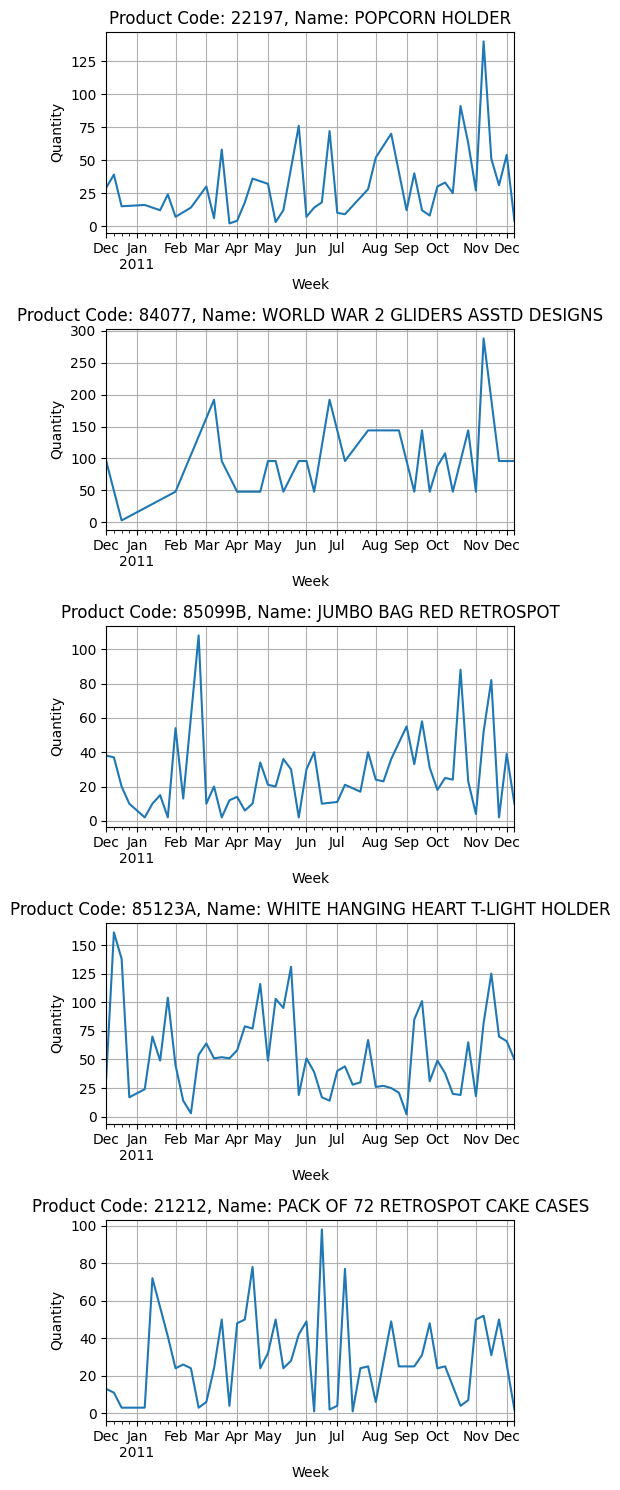

In [24]:
# Create subplots
fig, axes = plt.subplots(len(products_top), 1, figsize=(5, 3 * len(products_top)))

# Iterate over each product code
for i, code in enumerate(products_top):
    # Filter DataFrame for the current product code
    df_product = df_fltrd_0[df_fltrd_0['StockCode'] == code]
    
    # Group by week and calculate total sales, plot total sales per (week/day) for the current product code
    ax = df_product.groupby(df_product['InvoiceDate_noTime'].dt.to_period('W'))['Quantity'].sum().plot(ax=axes[i])

    ax.set_title(f"Product Code: {code}, Name: {df_fltrd_0[df_fltrd_0['StockCode'] == code].Description.mode()[0]}")
    ax.set_ylabel("Quantity")
    ax.set_xlabel("Week")
    ax.grid(True)

# Adjust layout and spacing
plt.tight_layout()
plt.show()